In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

import wandb

config={
    "lr": 1.8e-4,
    "dropout": 0.5,
    "architecture": "Efficientb4 + 3way",
    "dataset": "vanilla + mask",
    "augmentation" : "None",
    "age_weightedloss" : [1.0, 1.2, 3.0],
    "gender_weightedloss" : [1.4, 1.0],
    "gamma" : 0.85,
    "batch_size" : 64,
    "epochs" : 15
}

# wandb.init(project="MaskClassification", config=config)



In [6]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [7]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = Image.open(image_name)
        
        features = image_name.split('/')[-2:]
        
        masktoint = {'m' : 0, 'i' : 1, 'n' : 2}
        gendertoint = {'male' : 0, 'female' : 1}
        
        mask = masktoint[features[1][0]]
        age = int(features[0].split('_')[-1])
        gender = gendertoint[features[0].split('_')[1]]
        
        if age >= 58: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        if self.transform:
            image = self.transform(image)
        
        return image, (mask, gender, age)

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [9]:
from torch.utils.data.dataset import random_split
tfms = transforms.Compose([
#     transforms.RandomRotation(10),
    transforms.CenterCrop((400, 360)),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
])

dataset = TrainDataset(train_dir, transform=tfms)
train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.8),int(len(dataset)*0.2)])
# print(len(dataset))
# plt.imshow(np.array(train[1][0].permute(1,2,0)))
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, drop_last=False)
val_loader   = DataLoader(dataset=val_dataset, num_workers=4, batch_size=config['batch_size'])

## Model

In [10]:
from efficientnet_pytorch import EfficientNet

class Way3(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = EfficientNet.from_pretrained('efficientnet-b4', num_classes=512).to(device)
        self.mask = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.gender = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        self.age = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.best_f1 = 0
        
    def forward(self, x):
        features = self.convnet(x)
        mask = self.mask(features)
        gender = self.gender(features)
        age = self.age(features)
        
        return mask, gender, age
    
model = Way3().to(device)

Loaded pretrained weights for efficientnet-b4


In [7]:
import torch.optim as optim 

gender_weight = torch.tensor(config["gender_weightedloss"])
age_weight = torch.tensor(config["age_weightedloss"])
                             
criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss(weight=gender_weight).to(device)
age_criterion = nn.CrossEntropyLoss(weight=age_weight).to(device)
# b_criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['gamma'], verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check(loader, length, model, device):
    model.eval()
    val_loss = 0.0
    counter = 0
    y_true = []
    y_predicted = []
[0.5 0.3 0.2] [0]
    m_acc = []
    g_acc = []
    a_acc = []
    with torch.no_grad():
        for (inputs, (m, g, a)) in val_loader:
            counter += 1
            
            for mask, gender, age in zip(m, g, a):
                answer = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_true.append(answer)
            
            inputs = inputs.to(device=device)
            m = m.to(device)
            g = g.to(device)
            a = a.to(device)

            m_pred, g_pred, a_pred = model(inputs)
    
            m_loss = criterion(m_pred, m)
            g_loss = gender_criterion(g_pred, g)
            a_loss = age_criterion(a_pred, a) # data imbalance
            
            loss = (g_loss+a_loss+m_loss)
            
            val_loss += loss.item()
            
            m_argmax = m_pred.detach().cpu().numpy().argmax(1)
            g_argmax = g_pred.detach().cpu().numpy().argmax(1)
            a_argmax = a_pred.detach().cpu().numpy().argmax(1)

            m_acc.append(accuracy_score(m_argmax, m.detach().cpu().numpy()))
            g_acc.append(accuracy_score(g_argmax, g.detach().cpu().numpy()))
            a_acc.append(accuracy_score(a_argmax, a.detach().cpu().numpy()))

            for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
                predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_predicted.append(predicted)
    
    
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)

    s = 0
    for c in range(18):
        s += cm[c][c]
        
    print("< VALIDATION >")
    print("*"*73)
    print("Validation Loss :", val_loss/counter)
    print("-"*73)
    print("Total Accuracy")
    print(s / length * 100, "%")
    print("-"*73)
    print("Class Accuracy")
    print("Mask   :", np.mean(m_acc)*100, "%")
    print("Gender :", np.mean(g_acc)*100, "%")
    print("Age    :", np.mean(a_acc)*100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        print(row)
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
        torch.save(model.state_dict(), '/opt/ml/weights/3way_age/Aug_{}.pt'.format(model.best_f1))
        print("model saved!")
    print("*"*73)
    print()
    wandb.log({
        "Validation Loss" : val_loss/counter, 
        "Validation Total Accuracy" : s / length *100, 
        "Validation F1" : macro_F1,
        "Mask Accuracy" : np.mean(m_acc)*100,
        "Gender Accuracy" : np.mean(g_acc)*100,
        "Age Accuracy" : np.mean(a_acc)*100,
    })
        
    model.train()

In [9]:
for epoch in range(config['epochs']):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_dataset)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, (m, g, a)) in prog_bar:
        
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        m_pred, g_pred, a_pred = model(inputs)
        
        
        m = m.to(device)
        g = g.to(device)
        a = a.to(device)
        total += m.size(0)
        
        
        m_loss = criterion(m_pred, m)
        g_loss = gender_criterion(g_pred, g)
        a_loss = age_criterion(a_pred, a) # data imbalance
        
        
        loss = (g_loss+a_loss+m_loss)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter

            print("Loss :", train_loss)
            wandb.log({"Train Loss" : train_loss})
            
            check(val_loader, len(val_dataset), model, device)
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 253/506 [01:53<01:51,  2.27it/s]

Loss : 1.8989402055740356


 50%|█████     | 254/506 [02:08<20:59,  5.00s/it]

< VALIDATION >
Total Accuracy
85.1604938271605 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.34793307086615 %
Gender : 98.70816929133859 %
Age    : 86.80008748906387 %
-------------------------------------------------------------------------
Confusion Matrix
[524  26   0  15   5   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 10 269  32   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  48 113   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
[  3   1   0 658  72   0   0   0   0   3   0   0   0   0   0   0   0   0]
[  0   1   0   5 571  46   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  77 186   0   0   0   0   0   0   0   0   0   0   0   0]
[  8   0   0   0   0   0 548  10   0   3   5   0   0   0   0   0   0   0]
[  0   6   0   0   0   0  14 193  72   0  14   1   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  42 153   0   2   2   0   0   0   0   0   0]
[  0   0   0   4  

100%|█████████▉| 505/506 [03:59<00:00,  2.27it/s]

Loss : 1.749837015928487


100%|██████████| 506/506 [04:14<00:00,  4.97s/it]

< VALIDATION >
Total Accuracy
87.4074074074074 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.79084645669292 %
Gender : 97.50246062992126 %
Age    : 89.8649387576553 %
-------------------------------------------------------------------------
Confusion Matrix
[549  15   0   5   0   0   0   1   0   0   0   0   1   0   0   0   0   0]
[ 18 236  61   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  17 145   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 14   0   0 711  10   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  1  24   0  28 513  56   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   1   3   0  50 209   0   0   0   0   0   0   0   0   0   0   0   0]
[  2   0   0   0   0   0 567   4   0   1   0   0   0   0   0   0   0   0]
[  0   2   0   0   0   0  15 264  19   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  68 131   0   0   0   0   0   0   0   0   0]
[  0   0   0   3   

507it [04:15,  1.99it/s]                         

Adjusting learning rate of group 0 to 1.6000e-04.
Epoch : 2



 50%|█████     | 253/506 [01:52<01:52,  2.24it/s]

Loss : 1.54203914094159


 50%|█████     | 254/506 [02:07<20:50,  4.96s/it]

< VALIDATION >
Total Accuracy
90.5925925925926 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.72933070866141 %
Gender : 99.37253937007874 %
Age    : 91.45751312335958 %
-------------------------------------------------------------------------
Confusion Matrix
[557  10   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10 262  39   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0]
[  0  19 143   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 715  16   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   2 572  44   0   0   0   0   4   0   0   0   0   0   0   0]
[  0   0   1   0  31 229   0   0   0   0   0   2   0   0   0   0   0   0]
[  3   0   0   0   0   0 565   3   0   3   0   0   0   0   0   0   0   0]
[  0   2   0   0   0   0  11 207  80   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  11 188   0   0   0   0   0   0   0   0   0]
[  0   0   0   2  

100%|█████████▉| 505/506 [03:59<00:00,  2.26it/s]

Loss : 1.5322466447890513


100%|██████████| 506/506 [04:14<00:00,  4.95s/it]

< VALIDATION >
Total Accuracy
92.54320987654322 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.76624015748031 %
Gender : 99.59399606299213 %
Age    : 93.16491688538933 %
-------------------------------------------------------------------------
Confusion Matrix
[564   1   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 12 296   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  27 135   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 732   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0  34 574  15   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  49 212   0   0   0   0   0   2   0   0   0   0   0   0]
[  4   0   0   0   0   0 568   0   0   2   0   0   0   0   0   0   0   0]
[  1   2   0   0   0   0  17 254  24   1   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  33 166   0   0   0   0   0   0   0   0   0]
[  0   0   0   4 

507it [04:14,  1.99it/s]                         

Adjusting learning rate of group 0 to 1.2800e-04.
Epoch : 3



 50%|█████     | 253/506 [01:52<01:51,  2.26it/s]

Loss : 1.48648675032488


 50%|█████     | 254/506 [02:07<20:41,  4.93s/it]

< VALIDATION >
Total Accuracy
95.4074074074074 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.8892716535433 %
Gender : 99.48326771653542 %
Age    : 96.0288167104112 %
-------------------------------------------------------------------------
Confusion Matrix
[564   3   0   3   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 10 287  17   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   8 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   0   0 725   6   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   8 588  26   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  19 243   0   0   0   0   0   1   0   0   0   0   0   0]
[  2   0   0   0   0   0 571   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   9 262  28   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  14 185   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0

100%|█████████▉| 505/506 [03:58<00:00,  2.26it/s]

Loss : 1.4813267911375747


100%|██████████| 506/506 [04:14<00:00,  4.97s/it]

< VALIDATION >
Total Accuracy
95.91358024691358 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 99.58169291338582 %
Age    : 96.51137357830271 %
-------------------------------------------------------------------------
Confusion Matrix
[567   0   0   3   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 10 295   9   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   9 153   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 719  14   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   1 610  10   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   0   1   0  21 237   0   0   0   0   0   4   0   0   0   0   0   0]
[  2   0   0   0   0   0 568   3   0   1   0   0   0   0   0   0   0   0]
[  0   2   0   0   0   0   8 266  24   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   4 195   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 

507it [04:14,  1.99it/s]                         

Adjusting learning rate of group 0 to 1.0240e-04.
Epoch : 4



 50%|█████     | 253/506 [01:52<01:51,  2.26it/s]

Loss : 1.462945081117585


 50%|█████     | 254/506 [02:07<20:50,  4.96s/it]

< VALIDATION >
Total Accuracy
96.8395061728395 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.8892716535433 %
Gender : 99.74163385826772 %
Age    : 97.17574365704287 %
-------------------------------------------------------------------------
Confusion Matrix
[566   0   0   4   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 12 286  15   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   6 156   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 730   3   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   4 611   8   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  23 240   0   0   0   0   0   0   0   0   0   0   0   0]
[  2   0   0   0   0   0 568   2   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   7 266  25   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   4 195   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   

100%|█████████▉| 505/506 [03:58<00:00,  2.27it/s]

Loss : 1.4584506818428342


100%|██████████| 506/506 [04:14<00:00,  4.87s/it]

< VALIDATION >
Total Accuracy
96.92592592592592 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.8892716535433 %
Gender : 99.66781496062993 %
Age    : 97.35755686789152 %
-------------------------------------------------------------------------
Confusion Matrix
[566   2   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 12 297   4   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  18 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 731   1   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   0   0  16 601   6   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  13 249   0   0   0   0   0   1   0   0   0   0   0   0]
[  2   0   0   0   0   0 561   5   0   6   0   0   0   0   0   0   0   0]
[  0   2   0   0   0   0   6 281  10   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  14 185   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  

507it [04:14,  1.99it/s]                         

Adjusting learning rate of group 0 to 8.1920e-05.
Epoch : 5



 50%|█████     | 253/506 [01:52<01:51,  2.27it/s]

Loss : 1.4455527353474473


 50%|█████     | 254/506 [02:07<20:38,  4.92s/it]

< VALIDATION >
Total Accuracy
97.81481481481481 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.76624015748031 %
Age    : 98.1599956255468 %
-------------------------------------------------------------------------
Confusion Matrix
[569   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  8 299   6   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   6 156   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 731   1   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   3   0   3 591  23   0   0   0   0   3   0   0   0   0   0   0   0]
[  0   0   1   0   6 255   0   0   0   0   0   1   0   0   0   0   0   0]
[  2   0   0   0   0   0 571   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   8 276  15   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 197   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  

100%|█████████▉| 505/506 [03:58<00:00,  2.26it/s]

Loss : 1.4449718377806924


100%|██████████| 506/506 [04:14<00:00,  4.95s/it]

< VALIDATION >
Total Accuracy
97.80246913580247 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9507874015748 %
Gender : 99.58169291338582 %
Age    : 98.26798993875767 %
-------------------------------------------------------------------------
Confusion Matrix
[569   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7 298   8   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   3 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 732   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   2 609  11   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   6 257   0   0   0   0   0   0   0   0   0   0   0   0]
[  2   0   0   0   0   0 571   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   8 282   9   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   6 193   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  

507it [04:14,  1.99it/s]                         

Adjusting learning rate of group 0 to 6.5536e-05.
Epoch : 6



 50%|█████     | 253/506 [01:51<01:51,  2.27it/s]

Loss : 1.4399211082871504


 50%|█████     | 254/506 [02:07<20:40,  4.92s/it]

< VALIDATION >
Total Accuracy
98.12345679012346 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9015748031496 %
Gender : 99.80314960629921 %
Age    : 98.41562773403325 %
-------------------------------------------------------------------------
Confusion Matrix
[567   0   0   2   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
[  7 300   5   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0]
[  0   5 156   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
[  3   0   0 732   1   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   5 614   4   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   9 254   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 570   3   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   5 287   7   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  11 188   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  

 63%|██████▎   | 319/506 [02:36<01:31,  2.04it/s]


KeyboardInterrupt: 

In [17]:
# model.load_state_dict(torch.load('/opt/ml/weights/3way_{}.pt'.format(model.best_f1)))
model.load_state_dict(torch.load('/opt/ml/weights/3way_test_0.739.pt'))

<All keys matched successfully>

## Inference

In [18]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        m_pred, g_pred, a_pred = model(images)
#         print(images.shape)
#         print(m_pred.shape)
        m_argmax = m_pred.detach().cpu().numpy().argmax(1)
        g_argmax = g_pred.detach().cpu().numpy().argmax(1)
        a_argmax = a_pred.detach().cpu().numpy().argmax(1)
        
        for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
            predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
            all_predictions.append(predicted)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

  5%|▌         | 10/196 [00:01<00:28,  6.57it/s]


KeyboardInterrupt: 

Normal : 99.99727010726929 %
Female : 97.05613255500793 %
30 ~ 60 : 83.34801197052002 %


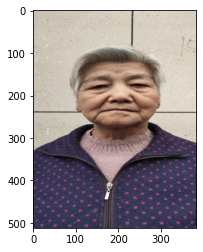

In [40]:
idx = 1030
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]


image = Image.open(image_paths[idx])
plt.imshow(image)
image = tfms(image).to(device)
image = image.unsqueeze(0)
m_pred, g_pred, a_pred = model(image)

m_argmax = m_pred.detach().cpu().numpy().argmax(1)
g_argmax = g_pred.detach().cpu().numpy().argmax(1)
a_argmax = a_pred.detach().cpu().numpy().argmax(1)

#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}
#
print(masklabel[m_argmax[0]]+ " :", (m_pred[0][m_argmax].item())*100, '%')
print(genderlabel[g_argmax[0]]+ " :", (g_pred[0][g_argmax].item())*100, '%')
print(agelabel[a_argmax[0]]+ " :", (a_pred[0][a_argmax].item())*100, '%')
